## Initialize the spark environment and load the helper functions we have provided

In [1]:
import sys
sys.path.append('/home/student/ROI/SparkProgram')

import pandas as pd
import matplotlib as mp
import numpy
from matplotlib import pyplot as plt
#from IPython.display import display

import pyspark_helpers as pyh
sc, spark, conf = pyh.initspark()
from pyspark_helpers import display

initializing pyspark
pyspark initialized


## Read in a simple dataset of Boston Housing Prices

In [150]:
#filename = 'avocado.csv'
#filename = 'HousingData.csv'
filename = 'boston.csv'
df = spark.read.csv(f'/home/student/ROI/Spark/{filename}', header = True, inferSchema = True)
display(df)
df.printSchema()

# Save a pointer to the raw data
dfRaw = df



,TOWN,TRACT,LON,LAT,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO
0,Nahant,2011,-70.9550,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3
1,Swampscott,2021,-70.9500,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8
2,Swampscott,2022,-70.9360,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8
3,Marblehead,2031,-70.9280,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7
4,Marblehead,2032,-70.9220,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7
5,Marblehead,2033,-70.9165,42.3040,28.7,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7
6,Salem,2041,-70.9360,42.2970,22.9,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2
7,Salem,2042,-70.9375,42.3100,22.1,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2
8,Salem,2043,-70.9330,42.3120,16.5,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2
9,Salem,2044,-70.9290,42.3160,18.9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2


root
 |-- TOWN: string (nullable = true)
 |-- TRACT: integer (nullable = true)
 |-- LON: double (nullable = true)
 |-- LAT: double (nullable = true)
 |-- MEDV: double (nullable = true)
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)



In [155]:
from pyspark.ml.feature import StringIndexer
col = 'TOWN'
indexer = StringIndexer(inputCol = col, outputCol = col+'_Index')
x = indexer.fit(df).transform(df).select(col, col+'_Index').distinct()
display(x.orderBy(col))
display(x.orderBy(col+'_Index'))



,TOWN,TOWN_Index
0,Arlington,23.0
1,Ashland,64.0
2,Bedford,61.0
3,Belmont,17.0
4,Beverly,27.0
5,Boston Allston-Brighton,18.0
6,Boston Back Bay,32.0
7,Boston Beacon Hill,54.0
8,Boston Charlestown,31.0
9,Boston Dorchester,12.0


,TOWN,TOWN_Index
0,Cambridge,0.0
1,Boston Savin Hill,1.0
2,Lynn,2.0
3,Boston Roxbury,3.0
4,Newton,4.0
5,Somerville,5.0
6,Boston South Boston,6.0
7,Quincy,7.0
8,Boston East Boston,8.0
9,Brookline,9.0


In [158]:
display(pyh.StringIndexEncode(df, ['TOWN', 'TRACT']))


,LON,LAT,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,TOWN_Index,TRACT_Index
0,-70.9550,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,77.0,167.0
1,-70.9500,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,74.0,279.0
2,-70.9360,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,74.0,127.0
3,-70.9280,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,56.0,405.0
4,-70.9220,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,56.0,352.0
5,-70.9165,42.3040,28.7,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,56.0,235.0
6,-70.9360,42.2970,22.9,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,25.0,61.0
7,-70.9375,42.3100,22.1,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,25.0,435.0
8,-70.9330,42.3120,16.5,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,25.0,282.0
9,-70.9290,42.3160,18.9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,25.0,166.0


In [163]:
col = 'TOWN'
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=[col + '_Index'], outputCols=[col+'_Vector'])
display(encoder.fit(x).transform(x).orderBy(col + '_Index'))

display(pyh.OneHotEncode(df10, ['TOWN', 'TRACT']))

display(pyh.AssembleFeatures(df11, categorical_features, numeric_features, 'target', False))



,TOWN,TOWN_Index,TOWN_Vector
0,Cambridge,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Boston Savin Hill,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Lynn,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Boston Roxbury,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Newton,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
5,Somerville,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
6,Boston South Boston,6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
7,Quincy,7.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
8,Boston East Boston,8.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
9,Brookline,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


,LON,LAT,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,TOWN_Vector,TRACT_Vector
0,-70.9550,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,-70.9500,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,-70.9360,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,-70.9280,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,-70.9220,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,-70.9165,42.3040,28.7,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,-70.9360,42.2970,22.9,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,-70.9375,42.3100,22.1,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,-70.9330,42.3120,16.5,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,-70.9290,42.3160,18.9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


,MEDV,features
0,24.0,"[0.00632, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2,..."
1,21.6,"[0.02731, 0.0, 7.07, 0.0, 0.469, 6.421, 78.9, ..."
2,34.7,"[0.02729, 0.0, 7.07, 0.0, 0.469, 7.185, 61.1, ..."
3,33.4,"[0.03237, 0.0, 2.18, 0.0, 0.458, 6.998, 45.8, ..."
4,36.2,"[0.06905, 0.0, 2.18, 0.0, 0.458, 7.147, 54.2, ..."
5,28.7,"[0.02985, 0.0, 2.18, 0.0, 0.458, 6.43, 58.7, 6..."
6,22.9,"[0.08829, 12.5, 7.87, 0.0, 0.524, 6.012, 66.6,..."
7,22.1,"[0.14455, 12.5, 7.87, 0.0, 0.524, 6.172, 96.1,..."
8,16.5,"[0.21124, 12.5, 7.87, 0.0, 0.524, 5.631, 100.0..."
9,18.9,"[0.17004, 12.5, 7.87, 0.0, 0.524, 6.004, 85.9,..."


['TOWN', 'TRACT', 'LON', 'LAT', 'MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO']


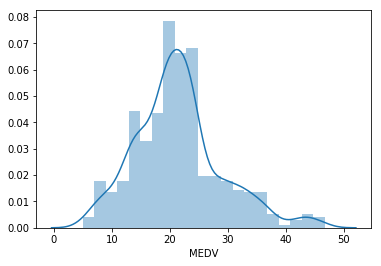

In [156]:
%matplotlib inline
import pandas as pd
import seaborn as sns
#sns.distplot(df.toPandas()['MEDV'])

sns.distplot(df.where('MEDV < 48').toPandas()['MEDV'])
print(df.columns)

# If we want to filter out the outliers
dfRaw = dfRaw.where('MEDV < 48')

In [148]:
if filename == 'avocado.csv':
    df = dfRaw.withColumnRenamed('4046','PLU4046').withColumnRenamed('4225','PLU4225').withColumnRenamed('4770','PLU4770')
    df.createOrReplaceTempView('dfRaw')
    df.printSchema()

    sql = '''select AveragePrice as target, `Total Volume` as totalvolume
    , PLU4046, PLU4225, PLU4770
    , `Small Bags` as smallbags, `Large Bags` as largebags, `XLarge Bags` as xlargebags
    , type, year, region
    FROM dfRaw'''

    df = spark.sql(sql)
    print(df)

    numeric_features = ['totalvolume','PLU4046', 'PLU4225', 'PLU4770', 'smallbags', 'largebags', 'xlargebags']
    categorical_features = ['type', 'year','region']
    target_label = 'target'
    print(df.take(1))
else:
    numeric_features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO']
    categorical_features = [] #['TOWN', 'TRACT']
    target_label = 'MEDV'
    df = dfRaw.select(categorical_features + numeric_features + [target_label])
    df.printSchema()

print ('******')
display(df.describe())

print ('******')
display(df)

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- MEDV: double (nullable = true)

******


,summary,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV
0,count,487,487,487,487,487,487,487,487,487,487,487,487
1,mean,3.663863696098563,10.944558521560575,11.155215605749499,0.059548254620123205,0.5544979466119098,6.233640657084198,68.29897330595482,3.835432854209443,9.537987679671458,408.8829568788501,18.541478439425056,21.466119096509257
2,stddev,8.745039991517844,22.587028902677194,6.820162970724796,0.23689130625554344,0.11678383814441988,0.6371816999531006,28.186892784939175,2.1144699664164612,8.711782762741368,168.18491396396433,2.094241632544032,7.580062510612899
3,min,0.00632,0.0,0.74,0,0.385,3.561,2.9,1.137,1,187,12.6,5.0
4,max,88.9762,100.0,27.74,1,0.871,8.78,100.0,12.1265,24,711,22.0,46.7


******


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,22.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,18.9


## Turn the dataframe into vectors



In [142]:
# import imp
# imp.reload(pyh)

# df10 = pyh.StringIndexEncode(df, categorical_features)
# display(df10)
# df11 = pyh.OneHotEncode(df10, categorical_features)
# display(df11)
# df12 = pyh.AssembleFeatures(df11, categorical_features, numeric_features, 'target', False)
# display(df12)

dfML = pyh.MakeMLDataFrame(df, categorical_features, numeric_features, target_label, False)
display(dfML)
dfML.printSchema()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,22.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,18.9


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,22.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,18.9


,MEDV,features
0,24.0,"[0.00632, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2,..."
1,21.6,"[0.02731, 0.0, 7.07, 0.0, 0.469, 6.421, 78.9, ..."
2,34.7,"[0.02729, 0.0, 7.07, 0.0, 0.469, 7.185, 61.1, ..."
3,33.4,"[0.03237, 0.0, 2.18, 0.0, 0.458, 6.998, 45.8, ..."
4,36.2,"[0.06905, 0.0, 2.18, 0.0, 0.458, 7.147, 54.2, ..."
5,28.7,"[0.02985, 0.0, 2.18, 0.0, 0.458, 6.43, 58.7, 6..."
6,22.9,"[0.08829, 12.5, 7.87, 0.0, 0.524, 6.012, 66.6,..."
7,22.1,"[0.14455, 12.5, 7.87, 0.0, 0.524, 6.172, 96.1,..."
8,16.5,"[0.21124, 12.5, 7.87, 0.0, 0.524, 5.631, 100.0..."
9,18.9,"[0.17004, 12.5, 7.87, 0.0, 0.524, 6.004, 85.9,..."


## Split the dataset into train and test

In [136]:
train, test = dfML.randomSplit([.7,.3], seed = 1000)
print (f'Training set row count {train.count()}')
print (f'Testing set row count {test.count()}')



Training set row count 353
Testing set row count 134


## Run Linear Regression

In [137]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='target', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train)
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

print("Root Mean Squared Error: {}\nR Squared (R2) {}".format(lrModel.summary.rootMeanSquaredError, lrModel.summary.r2))


Coefficients: [-0.09835471749252538,0.005332754299371162,-0.10096929421151506,0.0,-5.571116536805126,5.390710210756637,-0.042132054505705695,-0.42612539816791184,0.0,-0.004595425300618804,-0.5955258325154016]
Intercept: 9.933834380915346
Root Mean Squared Error: 4.054438240179903
R Squared (R2) 0.6990028588000552


## Run test data


In [138]:
lrPredictions = lrModel.transform(test)
display(lrPredictions.select("prediction","target","features"), 30)
from pyspark.ml.evaluation import RegressionEvaluator
lrEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="target",metricName="r2")
testResult = lrModel.evaluate(test)
print("Root Mean Squared Error on Test set: {}".format(testResult.rootMeanSquaredError))

,prediction,target,features
0,14.075878,5.6,"[25.0461, 0.0, 18.1, 0.0, 0.693, 5.987, 100.0,..."
1,4.096799,7.0,"[45.7461, 0.0, 18.1, 0.0, 0.693, 4.519, 100.0,..."
2,17.143433,7.2,"[18.0846, 0.0, 18.1, 0.0, 0.679, 6.434, 100.0,..."
3,9.429505,7.4,"[22.5971, 0.0, 18.1, 0.0, 0.7, 5.0, 89.5, 1.51..."
4,20.126603,7.5,"[10.8342, 0.0, 18.1, 0.0, 0.679, 6.782, 90.8, ..."
5,15.535494,8.2,"[15.1772, 0.0, 18.1, 0.0, 0.74, 6.152, 100.0, ..."
6,20.652893,8.4,"[11.8123, 0.0, 18.1, 0.0, 0.718, 6.824, 76.5, ..."
7,15.062837,8.4,"[13.6781, 0.0, 18.1, 0.0, 0.74, 5.935, 87.9, 1..."
8,10.603725,8.5,"[41.5292, 0.0, 18.1, 0.0, 0.693, 5.531, 85.4, ..."
9,9.132023,8.8,"[73.5341, 0.0, 18.1, 0.0, 0.679, 5.957, 100.0,..."


Root Mean Squared Error on Test set: 4.370645041749265


## Try Decision Tree Regression

In [139]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'target')
dtModel = dt.fit(train)
dtPredictions = dtModel.transform(test)
important = dtModel.featureImportances
print(type(important), important)
#importantDict = zip(important[1], important[2])
#print (importantDict)
print (important[3])
from pyspark.ml.evaluation import RegressionEvaluator
dtEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="target",metricName="rmse")
testResult = dtEvaluator.evaluate(dtPredictions)
print("Root Mean Squared Error: {}".format(testResult))
dfML.take(1)

<class 'pyspark.ml.linalg.SparseVector'> (11,[0,2,4,5,6,7,9],[0.10859419088727641,0.0060453392469445475,0.045454224743183905,0.6224025162676463,0.027041371742439833,0.17198143054495482,0.018480926567554196])
0.0
Root Mean Squared Error: 4.47445633864587


[Row(target=24.0, features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3]))]

## Try Gradient Boosted Tree

In [140]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'target', maxIter=10)
gbtModel = gbt.fit(train)
gbtPredictions = gbtModel.transform(test)
display(gbtPredictions.select('prediction', 'target', 'features'), 20)
from pyspark.ml.evaluation import RegressionEvaluator
gbtEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="target",metricName="rmse")
testResult = gbtEvaluator.evaluate(gbtPredictions)
print("Root Mean Squared Error: {}".format(testResult))


,prediction,target,features
0,7.598968,5.6,"[25.0461, 0.0, 18.1, 0.0, 0.693, 5.987, 100.0,..."
1,8.599530,7.0,"[45.7461, 0.0, 18.1, 0.0, 0.693, 4.519, 100.0,..."
2,12.127202,7.2,"[18.0846, 0.0, 18.1, 0.0, 0.679, 6.434, 100.0,..."
3,8.828955,7.4,"[22.5971, 0.0, 18.1, 0.0, 0.7, 5.0, 89.5, 1.51..."
4,11.965777,7.5,"[10.8342, 0.0, 18.1, 0.0, 0.679, 6.782, 90.8, ..."
5,12.582019,8.2,"[15.1772, 0.0, 18.1, 0.0, 0.74, 6.152, 100.0, ..."
6,9.000350,8.4,"[11.8123, 0.0, 18.1, 0.0, 0.718, 6.824, 76.5, ..."
7,12.266308,8.4,"[13.6781, 0.0, 18.1, 0.0, 0.74, 5.935, 87.9, 1..."
8,8.900450,8.5,"[41.5292, 0.0, 18.1, 0.0, 0.693, 5.531, 85.4, ..."
9,11.398968,8.8,"[73.5341, 0.0, 18.1, 0.0, 0.679, 5.957, 100.0,..."


Root Mean Squared Error: 4.115669108874538
